In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr

from osgeo import gdal
#from gistool import rasterize
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd

from scipy import stats
from scipy import integrate
from numpy import exp
import math
from pymannkendall import original_test as mk


import matplotlib as mpl
import matplotlib.pyplot as plt
## set the line width of the hatch
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import matplotlib.ticker as mticker

In [ ]:
# ds = xr.open_dataset('/portal1/dell/li-b/meteo/CHM_PRE_0.1dg_19612022.nc')
# ds1 = ds['pre'].sel(longitude=ds.longitude.values, latitude=ds.latitude.values, time=ds.time.values).to_dataset(name='vari')
# ds2 = ds1['vari'].sel(latitude=slice(24.45,34.05),longitude=slice(110.45,122.05),time=ds1.time.values).to_dataset(name='vari')
# ds3 = ds2['vari'].where(ds2['vari']!=-99.9, np.nan).to_dataset(name='vari')
# ds4 = ds3.resample(time='M').sum(skipna=True)

In [3]:
ds = xr.open_dataset('/portal1/dell/li-b/meteo/pre_0.05.nc')
ds1 = ds.resample(time='M').sum(skipna=True)
ds1.to_netcdf('/portal1/dell/li-b/multiregression/pre1.nc')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


## process raster

In [3]:
# ds3 has indeed filtered all nan values with no confusing with 0 values
ds3['vari'].sel(time='2022-08-31').to_dataset(name='vari').to_netcdf('/portal1/dell/li-b/meteo/krig.nc')

In [10]:
area_d = ds3.mean(dim=['latitude','longitude'],skipna=True)
df0 = pd.DataFrame({'time':area_d.time.values,'vari':area_d['vari'].values})
df0.set_index('time',inplace=True)
df2022 = df0['2022-01-01':'2022-12-31']
df2022.to_csv('/portal1/dell/li-b/meteo/df2022.csv')

## regional

In [3]:
def cal_month_ano_aver(ds1, mon):
    ds_m0 = ds1.sel(time=ds1['time.month'].isin([mon]))
    ds_m = ds_m0['vari'].values

    anos = np.zeros_like(ds_m)
    for i in range(0,ds_m.shape[2]):
        for j in range(0,ds_m.shape[1]):
            v1 = ds_m[:,j,i]
            date = np.arange(1961,2023)
            
            non_nan_count = np.count_nonzero(~np.isnan(v1))
            if non_nan_count > 1:
                tr = mk(v1, alpha=0.05).trend
                if tr=='increasing':
                    pvalue=1
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                elif tr=='decreasing':
                    pvalue=-1
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                elif tr=='no trend':
                    pvalue=np.nan
                    anos[:,j,i] = v1 - v1.mean()
            else:
                anos[:,j,i] = v1 - v1.mean()
                
    ds_ano = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                        coords={'time': (['time'], ds_m0.time.values), 
                                'lat': (['lat'], ds_m0.lat.values),
                        'lon': (['lon'], ds_m0.lon.values),})
    return ds_ano

In [4]:
def cal_3month_ano_aver(ds1, mon1, mon2, mon3):
    ds_m0 = ds1.sel(time=ds1['time.month'].isin([mon1, mon2, mon3]))
    ds_m1 = ds_m0.groupby('time.year').sum(dim='time',skipna=True)
    ds_m = ds_m1['vari'].values

    anos = np.zeros_like(ds_m)

    for i in range(0,ds_m.shape[2]):
        for j in range(0,ds_m.shape[1]):
            v1 = ds_m[:,j,i]
            date = np.arange(1961,2023)
            
            non_nan_count = np.count_nonzero(~np.isnan(v1))
            if non_nan_count > 1:
                tr = mk(v1, alpha=0.05).trend
                if tr=='increasing':
                    pvalue=1
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                elif tr=='decreasing':
                    pvalue=-1
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                elif tr=='no trend':
                    pvalue=np.nan
                    anos[:,j,i] = v1 - v1.mean()
            else:
                anos[:,j,i] = v1 - v1.mean()
                
    ds_ano = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                        coords={'time': (['time'], ds_ano7.time.values), 
                                'lat': (['lat'], ds_m0.lat.values),
                        'lon': (['lon'], ds_m0.lon.values),})
    return ds_ano

In [6]:
ds_ano6 = cal_month_ano_aver(ds1, 6)
ds_ano7 = cal_month_ano_aver(ds1, 7)
ds_ano8 = cal_month_ano_aver(ds1, 8)
ds_ano9 = cal_month_ano_aver(ds1, 9)
ds_ano789 = cal_3month_ano_aver(ds1, 7, 8, 9)

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [7]:
ds_ano789.to_netcdf('/portal1/dell/li-b/multiregression/pre.nc')

In [18]:
c6 = ds_ano6['vari'].mean(dim=['lat','lon'],skipna=True).values
c7 = ds_ano7['vari'].mean(dim=['lat','lon'],skipna=True).values
c8 = ds_ano8['vari'].mean(dim=['lat','lon'],skipna=True).values
c9 = ds_ano9['vari'].mean(dim=['lat','lon'],skipna=True).values
c789 = ds_ano789['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range('1961','2023',freq='Y')
df1 = pd.DataFrame({'time':times,'jun_ano':c6, 'jul_ano':c7,'agu_ano':c8,'sep_ano':c9,'jas_ano':c789})
df1

,time,jun_ano,jul_ano,agu_ano,sep_ano,jas_ano
0,1961-12-31,-27.656963,-43.398838,20.309103,77.536339,51.354923
1,1962-12-31,64.529221,-23.031927,29.553600,45.230282,48.761631
2,1963-12-31,-64.119171,1.015399,20.642199,-0.775539,17.993103
3,1964-12-31,48.552727,-54.683670,-16.836088,-14.333014,-88.640366
4,1965-12-31,-34.327084,9.495947,24.890366,-35.628082,-3.927995
...,...,...,...,...,...,...
57,2018-12-31,-58.001759,-15.010620,20.204409,1.091986,8.971995
58,2019-12-31,35.316597,35.114014,-42.661991,-55.281208,-60.041599
59,2020-12-31,78.746033,120.453728,-19.977331,60.473331,163.838684
60,2021-12-31,-45.500019,33.784180,54.500061,-19.670681,71.603882


In [19]:
d6_0 = ds_ano6['vari'][61,:,:].values
box6 = d6_0[~np.isnan(d6_0)].ravel()

d7_0 = ds_ano7['vari'][61,:,:].values
box7 = d7_0[~np.isnan(d7_0)].ravel()

d8_0 = ds_ano8['vari'][61,:,:].values
box8 = d8_0[~np.isnan(d8_0)].ravel()

d9_0 = ds_ano9['vari'][61,:,:].values
box9 = d9_0[~np.isnan(d9_0)].ravel()

d789_0 = ds_ano789['vari'][61,:,:].values
box789 = d789_0[~np.isnan(d789_0)].ravel()

box = [box6,box7,box8,box9,box789]
for i in box:
    lo = np.nanpercentile(i,q=25)
    up = np.nanpercentile(i,q=75)
    upbo = up+1.5*(up-lo)
    lobo = lo-1.5*(up-lo)
    maxmum = i.max()
    minmum = i.min()
    print(upbo, lobo, maxmum, minmum)

166.5111322402954 -137.87084865570068 623.0376 -211.45526
117.9722785949707 -196.62046432495117 198.78593 -204.02425
-8.532968521118164 -185.3517246246338 47.693947 -261.03604
-17.844924449920654 -131.65162992477417 331.88577 -228.28693
26.38797950744629 -440.3163204193115 129.50797 -593.3622


/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Jun. PRE Anomalies')

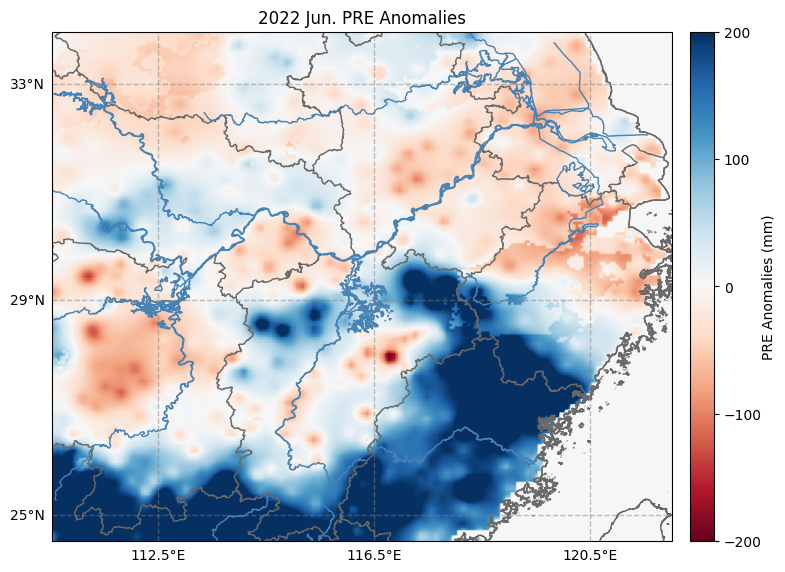

In [21]:
data = ds_ano6['vari'][61,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano6.lat.values, ds_ano6.lon.values

vmax=200
vmin=-200
cmap = plt.get_cmap('RdBu')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('PRE Anomalies (mm)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Jun. PRE Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Jul. PRE Anomalies')

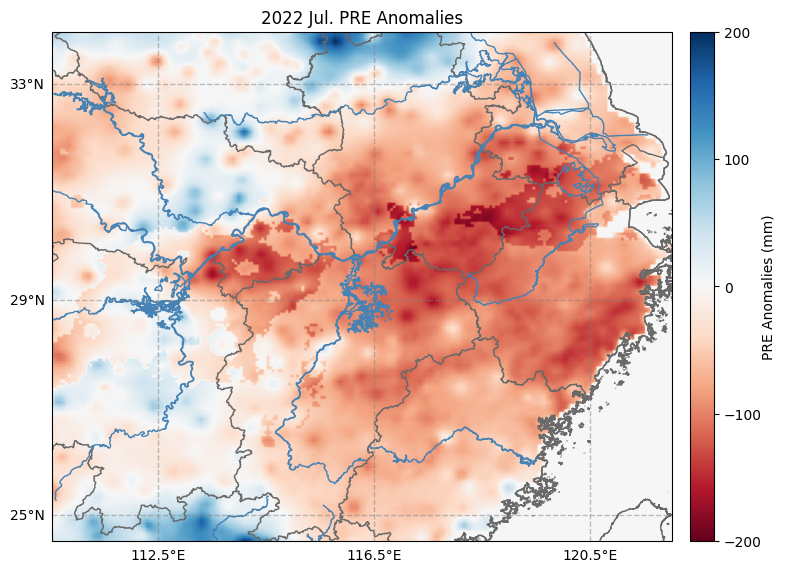

In [22]:
data = ds_ano7['vari'][61,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano6.lat.values, ds_ano6.lon.values

vmax=200
vmin=-200
cmap = plt.get_cmap('RdBu')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('PRE Anomalies (mm)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Jul. PRE Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Aug. PRE Anomalies')

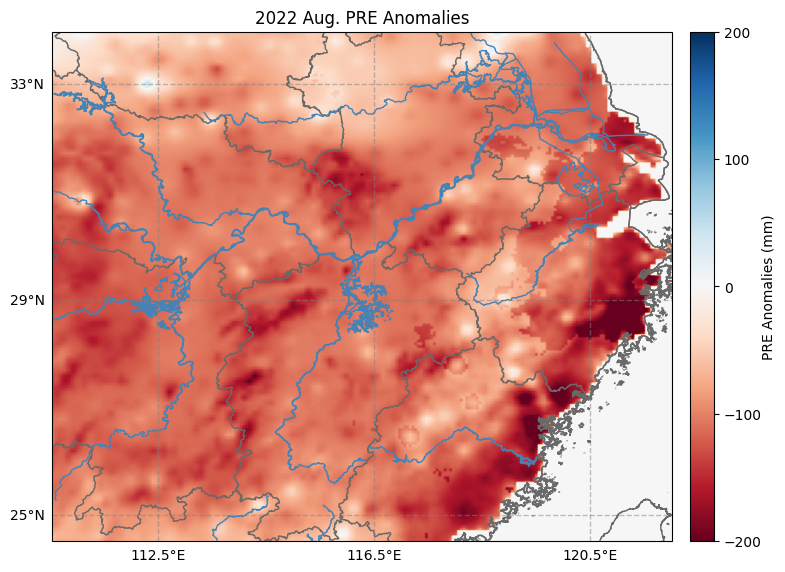

In [23]:
data = ds_ano8['vari'][61,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano6.lat.values, ds_ano6.lon.values

vmax=200
vmin=-200
cmap = plt.get_cmap('RdBu')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('PRE Anomalies (mm)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Aug. PRE Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Sep. PRE Anomalies')

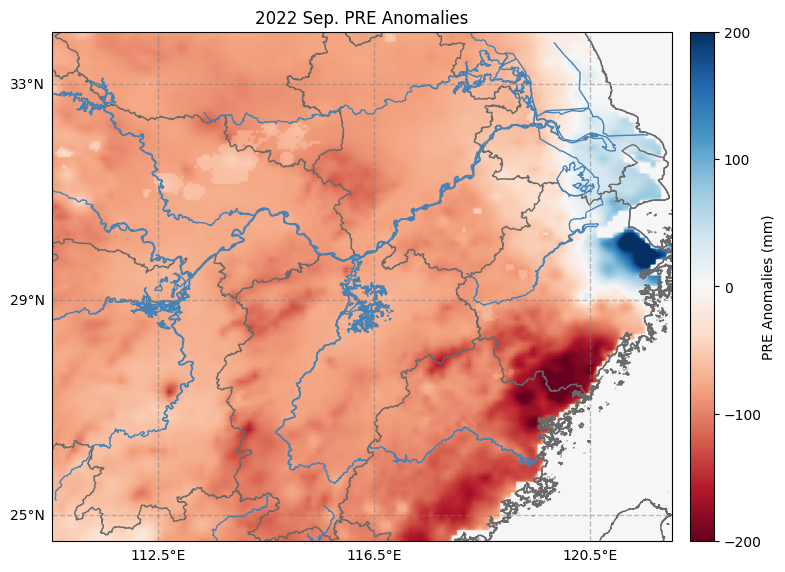

In [24]:
data = ds_ano9['vari'][61,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano6.lat.values, ds_ano6.lon.values

vmax=200
vmin=-200
cmap = plt.get_cmap('RdBu')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('PRE Anomalies (mm)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Sep. PRE Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 JAS PRE Anomalies')

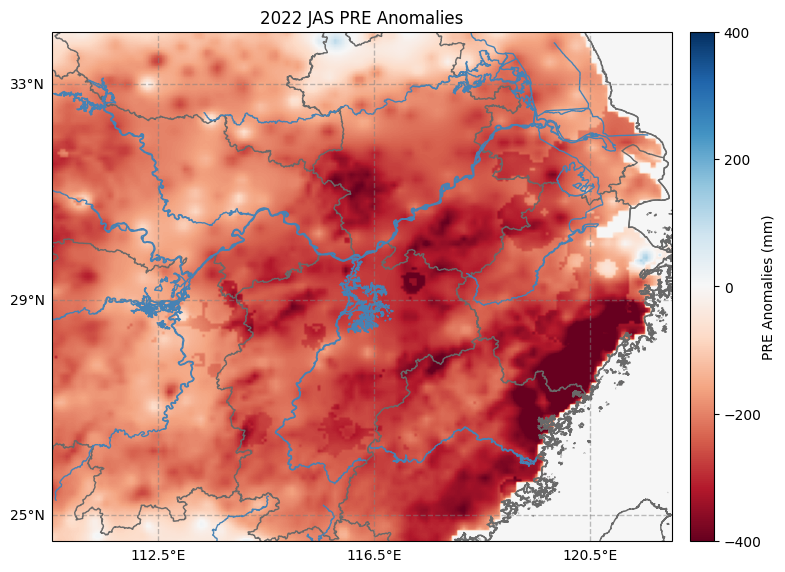

In [25]:
data = ds_ano789['vari'][61,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano6.lat.values, ds_ano6.lon.values

vmax=400
vmin=-400
cmap = plt.get_cmap('RdBu')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('PRE Anomalies (mm)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 JAS PRE Anomalies')

## cal areamean

In [11]:
# first pixelly sum daily pre to monthly, then calculate the area mean
area = ds4.mean(dim=['latitude','longitude'],skipna=True) 
df = pd.DataFrame({'time':area.time.values,'vari':area['vari'].values})
df.set_index('time',inplace=True)
df

,vari
time,
1961-01-31,29.729374
1961-02-28,73.978203
1961-03-31,136.095520
1961-04-30,143.375351
1961-05-31,157.245270
...,...
2022-08-31,46.535576
2022-09-30,21.714369
2022-10-31,38.384132


In [12]:
df_6 = df['vari'].loc[df.index.month==6].values
df_7 = df['vari'].loc[df.index.month==7].values
df_8 = df['vari'].loc[df.index.month==8].values
df_9 = df['vari'].loc[df.index.month==9].values
times = pd.date_range('1961','2023',freq='Y')

df1 = pd.DataFrame({'time':times,'jun':df_6,'jul':df_7,'aug':df_8,'sep':df_9})
df1['jas'] = df1['jul'] + df1['aug'] + df1['sep']
df1.set_index('time',inplace=True)
df1

,jun,jul,aug,sep,jas
time,,,,,
1961-12-31,166.161804,108.772385,152.426819,167.389389,428.588623
1962-12-31,257.829437,130.485367,163.266373,136.233505,429.985229
1963-12-31,130.019394,154.482773,154.157593,89.652008,398.292389
1964-12-31,241.644135,98.475677,116.224701,75.181465,289.881836
1965-12-31,160.228058,164.399780,158.719116,53.121979,376.240875
...,...,...,...,...,...
2018-12-31,141.415543,148.199982,160.891830,90.028824,399.120605
2019-12-31,234.789047,198.082565,98.105370,33.784195,329.972107
2020-12-31,279.073944,284.310211,120.111397,148.718552,553.140137


In [13]:
date = np.arange(1961,2023)
results = {}

for column in df1.columns:
    v1 = df1[column].values
    
    tr = mk(v1, alpha=0.05).trend
    if tr=='increasing':
        pvalue=1
        slo = stats.linregress(date,v1).slope
        interc = stats.linregress(date,v1).intercept
        trend = slo*date + interc
        df1[column+'_ano'] = df1[column].values - trend
    elif tr=='decreasing':
        pvalue=-1
        slo = stats.linregress(date,v1).slope
        interc = stats.linregress(date,v1).intercept
        trend = slo*date + interc
        df1[column+'_ano'] = df1[column].values - trend
    elif tr=='no trend':
        pvalue=np.nan
        df1[column+'_ano'] = df1[column].values - df1[column].values.mean() 
    
    results[column] = (slo, pvalue)
results

{'jun': (1.1704628251241378, nan),
 'jul': (0.6908438272541754, 1),
 'aug': (0.3604191976560067, 1),
 'sep': (0.3604191976560067, nan),
 'jas': (0.3604191976560067, nan)}

In [14]:
df1

,jun,jul,aug,sep,jas,jun_ano,jul_ano,aug_ano,sep_ano,jas_ano
time,,,,,,,,,,
1961-12-31,166.161804,108.772385,152.426819,167.389389,428.588623,-30.599442,-28.554111,26.826160,78.054291,44.262817
1962-12-31,257.829437,130.485367,163.266373,136.233505,429.985229,61.068192,-7.531972,37.305294,46.898407,45.659424
1963-12-31,130.019394,154.482773,154.157593,89.652008,398.292389,-66.741852,15.774590,27.836095,0.316910,13.966583
1964-12-31,241.644135,98.475677,116.224701,75.181465,289.881836,44.882889,-40.923349,-10.457216,-14.153633,-94.443970
1965-12-31,160.228058,164.399780,158.719116,53.121979,376.240875,-36.533188,24.309910,31.676780,-36.213120,-8.084930
...,...,...,...,...,...,...,...,...,...,...
2018-12-31,141.415543,148.199982,160.891830,90.028824,399.120605,-55.345703,-28.504612,14.747277,0.693726,14.794800
2019-12-31,234.789047,198.082565,98.105370,33.784195,329.972107,38.027802,20.687128,-48.399603,-55.550903,-54.353699
2020-12-31,279.073944,284.310211,120.111397,148.718552,553.140137,82.312698,106.223930,-26.753995,59.383453,168.814331


In [15]:
df1.to_csv('/portal1/dell/li-b/meteo/df1.csv')

## plot prr & pre_ano

In [2]:
pprr = pd.read_csv('/portal1/dell/li-b/meteo/PPRR1.csv')
pprr

,YEAR,IN,OUT,ET,PRR,jas_ano
0,1961,1.580000e+15,1.490000e+15,4.770000e+14,13.104088,44.262817
1,1962,1.030000e+15,1.070000e+15,4.830000e+14,19.034676,45.659424
2,1963,1.280000e+15,1.300000e+15,4.490000e+14,14.895388,13.966583
3,1964,1.640000e+15,1.660000e+15,4.790000e+14,12.728908,-94.443970
4,1965,1.050000e+15,1.250000e+15,4.770000e+14,18.486847,-8.084930
...,...,...,...,...,...,...
57,2018,8.960000e+14,7.680000e+14,4.760000e+14,20.998296,14.794800
58,2019,3.010000e+14,3.110000e+14,4.670000e+14,43.692489,-54.353700
59,2020,1.100000e+15,1.410000e+15,4.350000e+14,16.517370,168.814330
60,2021,9.600000e+14,8.500000e+14,4.560000e+14,19.184435,80.721344


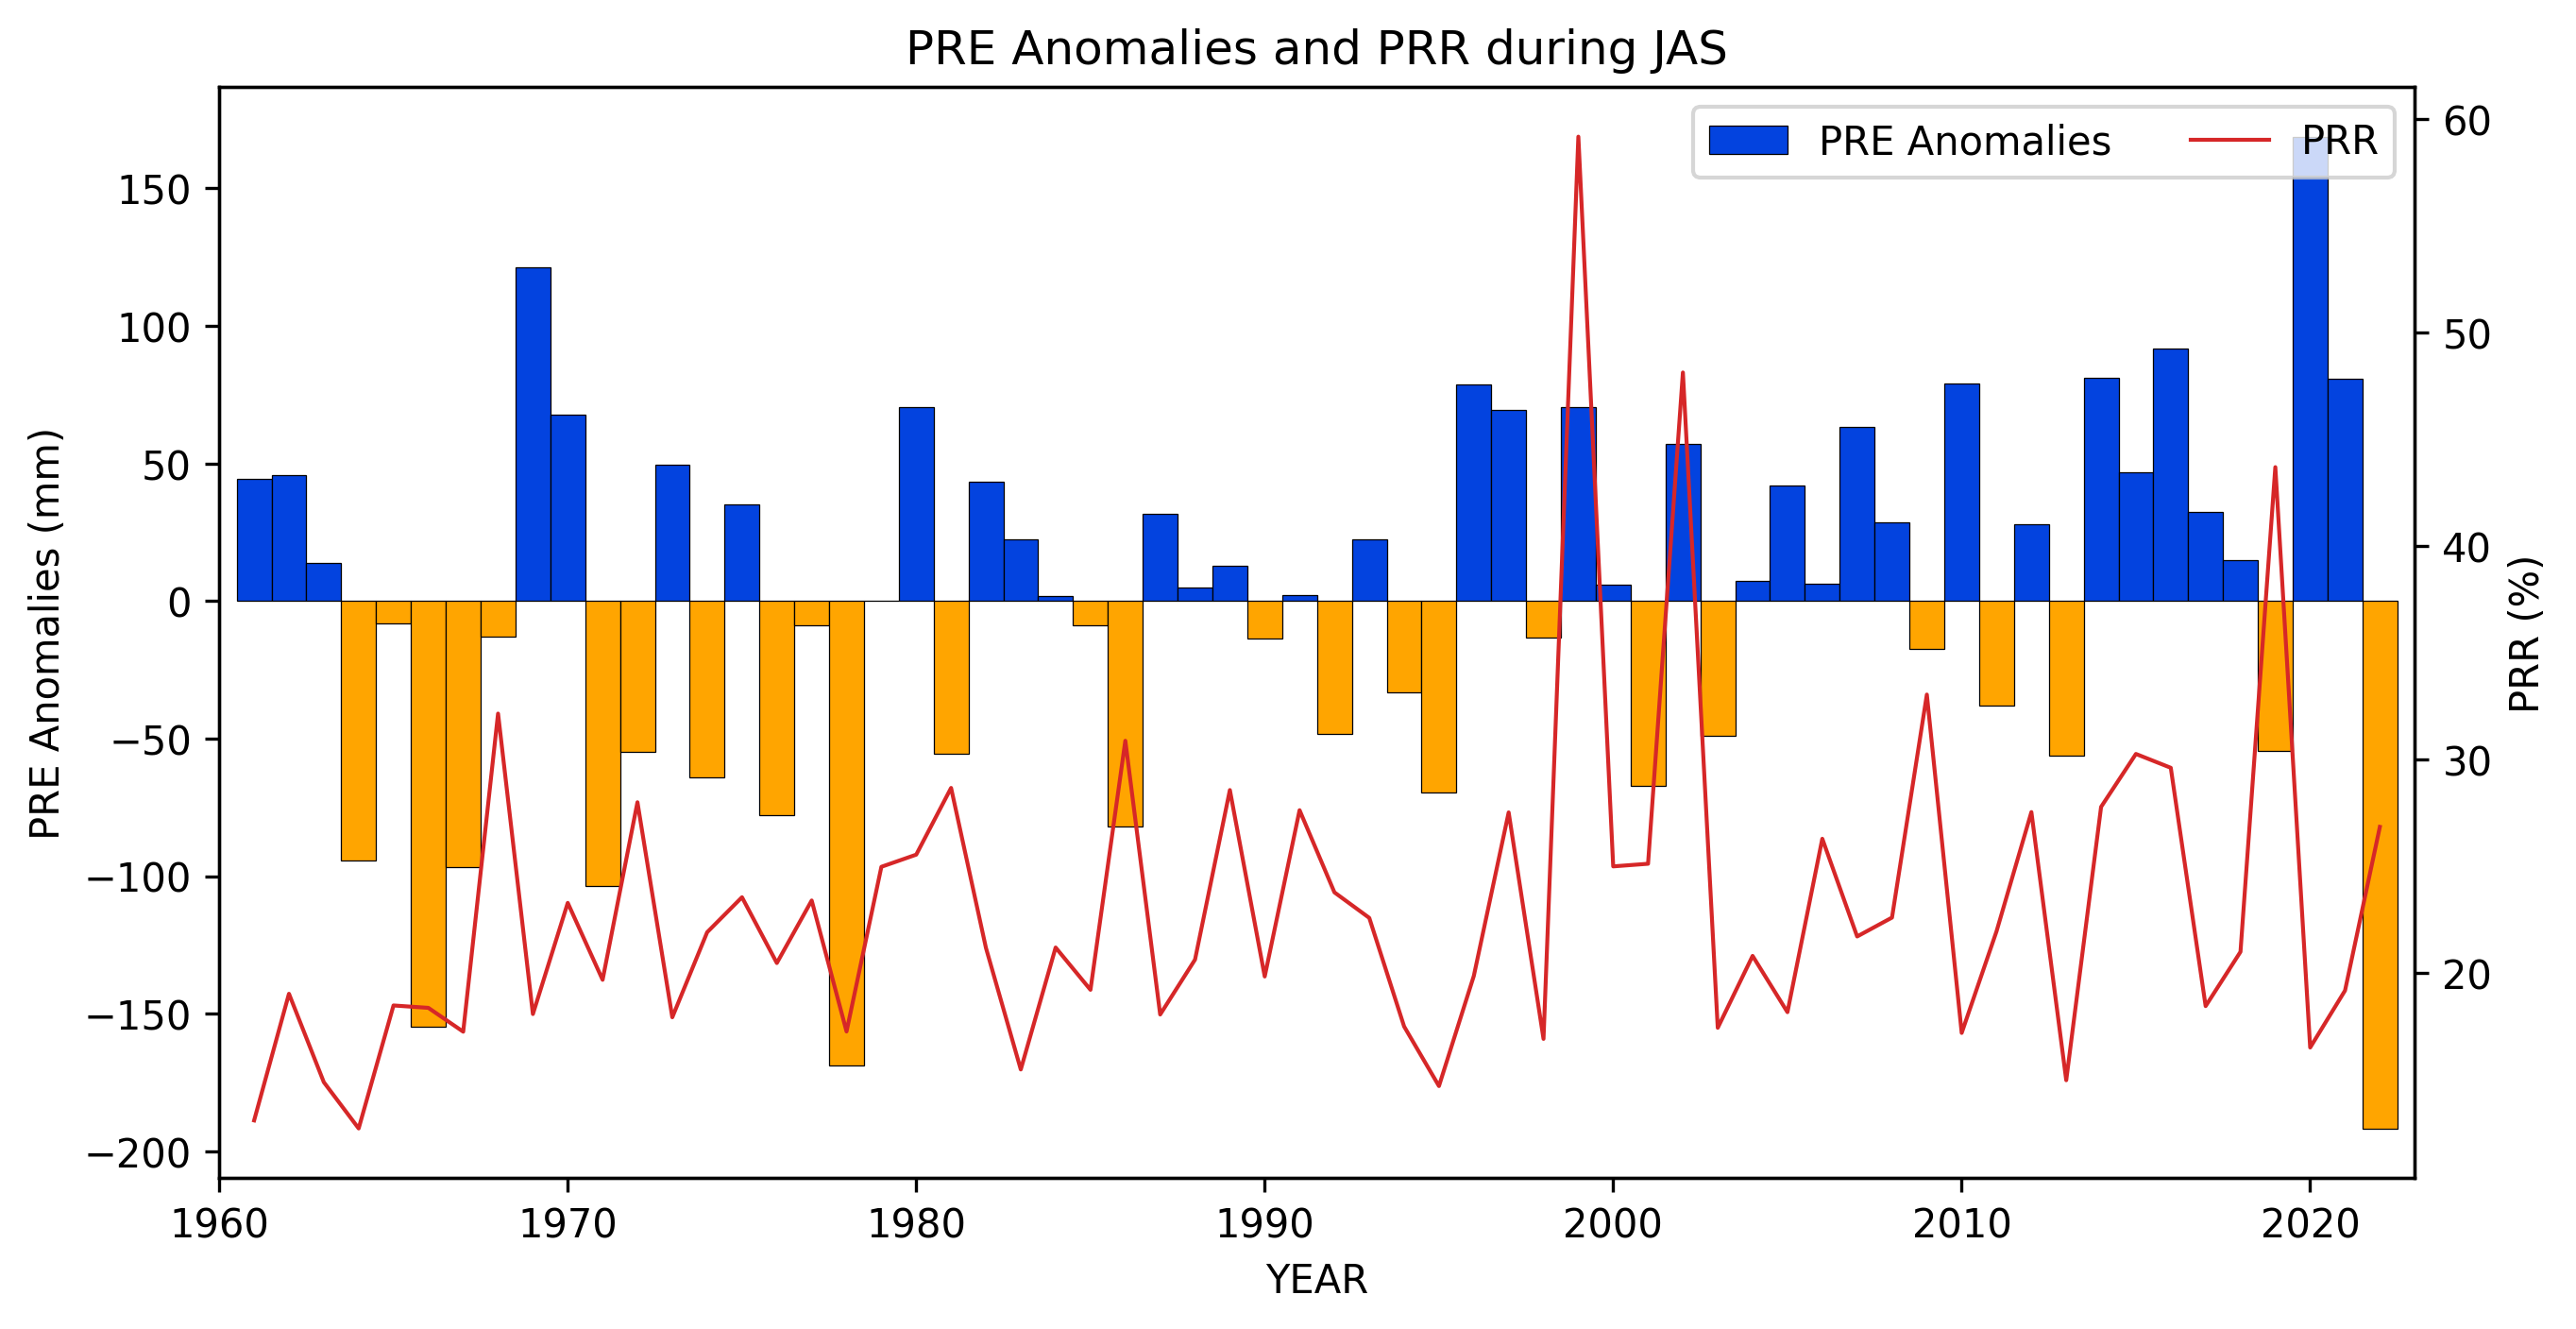

In [7]:
date = np.arange(1961,2023)
v1 = pprr['jas_ano']
v2 = pprr['PRR']

fig, ax = plt.subplots(1,1,dpi=300,figsize=(10,5))



colors = ['#0343DF' if v > 0 else 'orange' for v in v1]
ax.bar(date, v1, width=1, linewidth=0.3, color=colors, edgecolor='black', label='PRE Anomalies')

ax1 = ax.twinx()
ax1.plot(date, v2,color='tab:red',lw=1, ls='-', label='PRR')

ax.set_ylabel('PRE Anomalies (mm)')
ax1.set_ylabel('PRR (%)')
ax.set_xlabel('YEAR')
    
#figname = filename.replace('.txt','')
ax.set_title('PRE Anomalies and PRR during JAS')
ax.set_xlim(date[0]-1, date[-1]+1)
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes,ncol=2)

#plt.savefig('D:/rice/figs/middleyield.png')                         
plt.show()

## 2019 & 2022 daily

In [13]:
areamean = p3.mean(dim=['latitude','longitude']) 
#pre19 = areamean.sel(time=slice('2019-01-01T00:00:00.000000000','2019-12-31T00:00:00.000000000'))
pre22 = areamean.sel(time=slice('2022-01-01T00:00:00.000000000','2022-12-31T00:00:00.000000000'))

In [14]:
#df19 = pd.DataFrame(pre19['pre'].values,columns=['pre'])
df22 = pd.DataFrame(pre22['pre'].values,columns=['pre'])
df22

,pre
0,0.017780
1,0.000386
2,0.001752
3,1.137882
4,6.732278
...,...
360,0.392884
361,1.237312
362,1.702959
363,0.040345


In [15]:
df19 = pd.read_csv('D:/CHM_PRE/df19.csv')
df22 = pd.read_csv('D:/CHM_PRE/df22.csv')

In [16]:
t19 = pd.read_table('D:/datasets1/2019T.txt')
t22 = pd.read_table('D:/datasets1/2022T.txt')

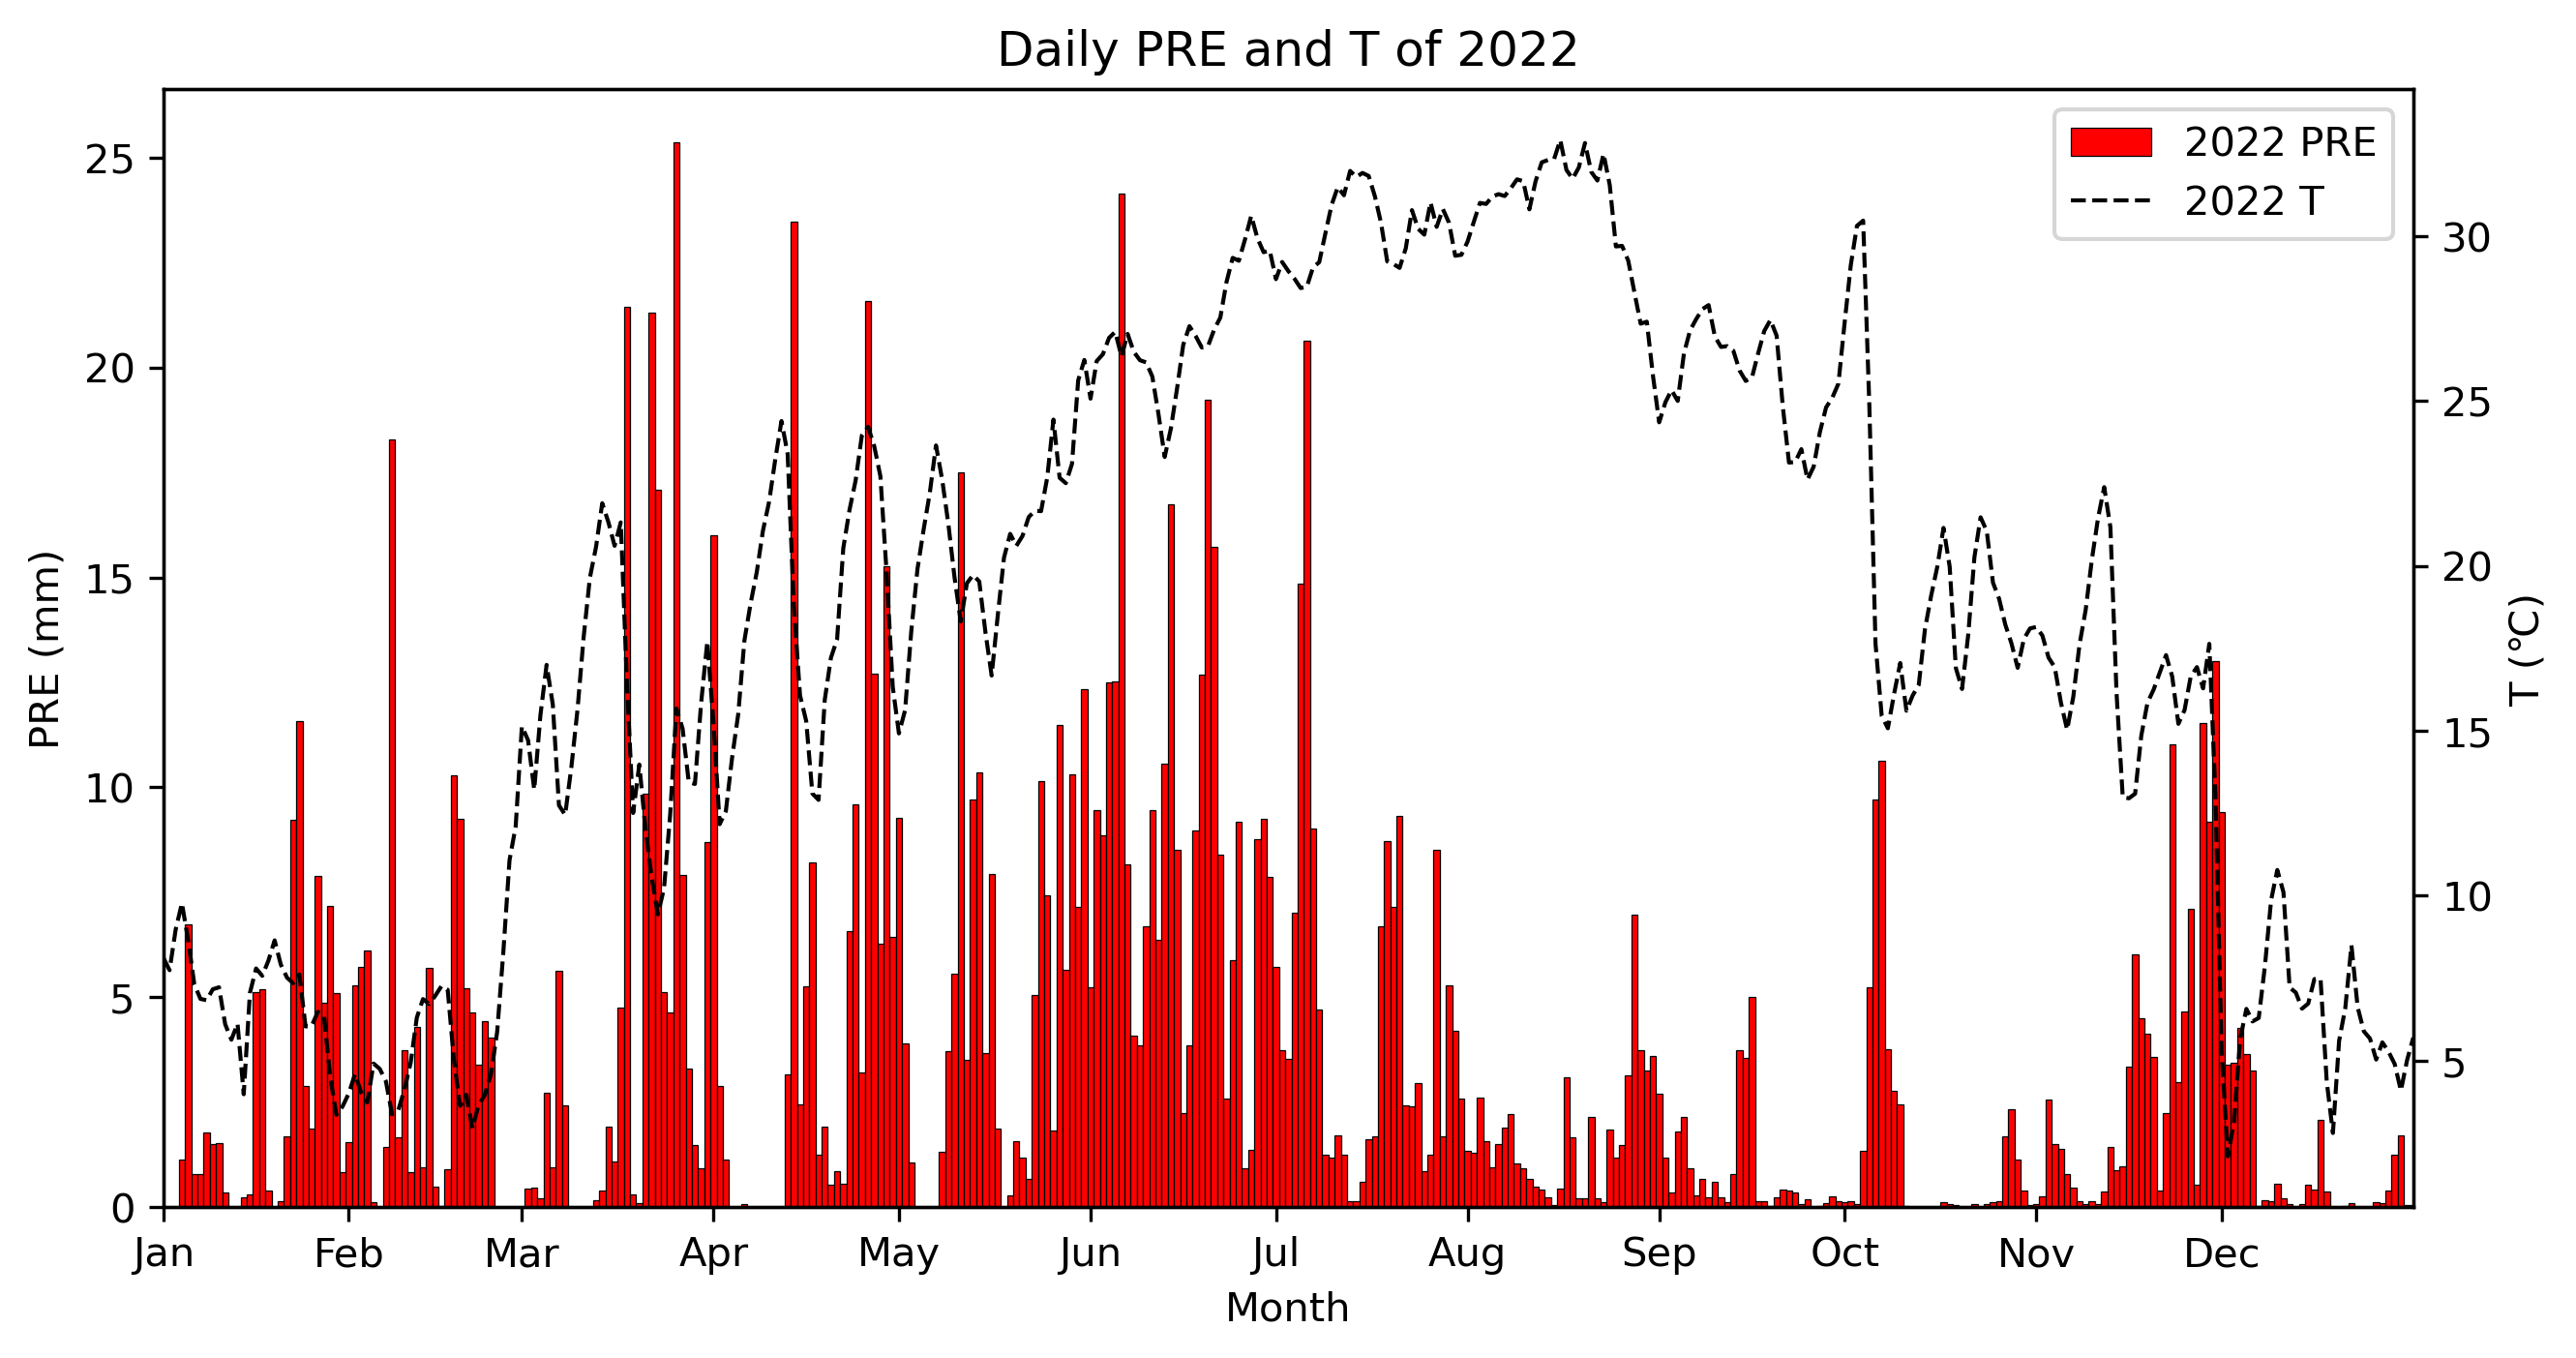

In [23]:
date = np.arange(1,366)
v1 = df19['pre']
v2 = df22['pre']
v3 = t19['T']
v4 = t22['T']

fig, ax = plt.subplots(1,1,dpi=300,figsize=(10,5))


ax1 = ax.twinx()
# ax1.plot(date, v3,color='seagreen',lw=1, ls='--', label='2019 T')
ax1.plot(date, v4,color='black',lw=1, ls='--', label='2022 T')





#colors = ['#0343DF' if v > 0 else 'orange' for v in v1]
# ax.bar(date, v1, width=1, linewidth=0.3, color='royalblue', edgecolor='black',label='2019 PRE')
ax.bar(date, v2, width=1, linewidth=0.3, color='red', edgecolor='black',label='2022 PRE')
#ax.plot(date,v1,lw=0.5,ls='-',color='blue', label='2019')


ax.set_ylabel('PRE (mm)')
ax1.set_ylabel('T (℃)')
ax.set_xlabel('Month')

ax.set_xticks([1,31,59,90,120,151,181,212,243,273,304,334])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

#figname = filename.replace('.txt','')
ax.set_title('Daily PRE and T of 2022')
ax.set_xlim(date[0], date[-1])
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)

#plt.savefig('D:/rice/figs/middleyield.png')                         
plt.show()

In [6]:

# lon = ds_m0.longitude.values
# lat = ds_m0.latitude.values

# # dx = np.diff(lon).mean() / 2
# # dy = np.diff(lat).mean() / 2
# # extent = [max(np.min(lon) - dx, -179.99), 
# #           min(np.max(lon) + dx, 179.99), 
# #           max(np.min(lat) + dy, -89.99),
# #           min(np.max(lat) - dy, 89.99)]
# data_extent = [lon.min(), lon.max(), lat.min(), lat.max()]

# cmap = plt.get_cmap('RdBu')

# fig = plt.figure(figsize=(8, 10))

# ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# im = ax.imshow(data, extent=data_extent, cmap=cmap,transform=ccrs.PlateCarree())

# # # Read the shapefile and filter it to match the data extent
# # bound = gpd.read_file('/portal1/dell/li-b/meteo/Export_Output.shp')

# # # Filter the GeoDataFrame to match the data extent
# # bound = bound.cx[extent[0]:extent[1], extent[2]:extent[3]]

# # # Plot the filtered GeoDataFrame
# # bound.plot(ax=ax, color='grey', linewidth=1)

# vmin = -200
# vmax = 200
# im.set_clim(vmin=vmin, vmax=vmax)

# ticks = list(np.linspace(vmin+10, vmax-10, 5))
# norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# pos = ax.get_position()
# pad = 0.015*1.5
# width = 0.015*2
# clen = 0.6
# cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
# cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
# cbar.ax.set_ylabel('PRE Anomalies (mm)')
# cbar.set_ticks(ticks)

# ax.set_xticks(np.arange(110.6, 122, 4), crs=ccrs.PlateCarree())
# ax.set_yticks(np.arange(34, 24.5, -4), crs=ccrs.PlateCarree())
# # ax.set_xticks(lon[::20], crs=ccrs.PlateCarree())
# # ax.set_yticks(lat[::5], crs=ccrs.PlateCarree())
# lon_formatter = LongitudeFormatter(zero_direction_label=True)
# lat_formatter = LatitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)

# ax.set_title('2022 Sep. PRE Anomalies')